# Brazilian E-Commerce Public Dataset by Olist

This noteebok works with a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. 

This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses.

The analysis is a compilation of differents notebooks and tries to be a tool for learning; thanks to the different people who worked on original notebooks. The reference it will be find at the below of the notebook

### 1.- Libraries

In [2]:
#standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

#Utilities
import viz_utils
from viz_utils import *


c:\Users\Yira\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 2.- Reading the data

In [3]:
#reading all the files
olist_customer=pd.read_csv("Datasets//olist_customers_dataset.csv")
olist_geolocation=pd.read_csv("Datasets//olist_geolocation_dataset.csv")
olist_orders = pd.read_csv("Datasets//olist_orders_dataset.csv")
olist_order_items = pd.read_csv("Datasets//olist_order_items_dataset.csv")
olist_order_payments = pd.read_csv("Datasets//olist_order_payments_dataset.csv")
olist_order_reviews = pd.read_csv("Datasets//olist_order_reviews_dataset.csv")
olist_products = pd.read_csv("Datasets//olist_products_dataset.csv")
olist_sellers = pd.read_csv("Datasets//olist_sellers_dataset.csv")
olist_products_translation=pd.read_csv("Datasets//product_category_name_translation.csv")
geo=pd.read_csv("Datasets//olist_geolocation_dataset.csv")

#### 2.1 Overview from the data
Before creating a unique dataset with useful information, let's look at the shape of each dataset, so we can be more assertive on how to use joining statements

In [4]:
# Collections for each dataset
datasets = [olist_customer, olist_geolocation, olist_orders, olist_order_items, olist_order_payments,
            olist_order_reviews, olist_products, olist_sellers]
names = ['olist_customer', 'olist_geolocation', 'olist_orders', 'olist_order_items', 'olist_order_payments',
         'olist_order_reviews', 'olist_products', 'olist_sellers']

# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
#[df.shape[0] for df in datasets] gives number of row count
data_info['n_rows'] = [df.shape[0] for df in datasets]
#[df.shape[1] for df in datasets] gives number of col count
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum()for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets] #which columns have nulls
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info.style.background_gradient()

,dataset,n_rows,n_cols,null_amount,qty_null_columns,null_columns
0,olist_customer,99441,5,0,0,
1,olist_geolocation,1000163,5,0,0,
2,olist_orders,99441,8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
3,olist_order_items,112650,7,0,0,
4,olist_order_payments,103886,5,0,0,
5,olist_order_reviews,99224,7,145903,2,"review_comment_title, review_comment_message"
6,olist_products,32951,9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,olist_sellers,3095,4,0,0,


Now let's use a homemade function by Thiago Panini found on the module viz_utils.py for looking at each and bring some detailed parameters about the data content. With this functions we can get the following information for each data set column;

- Column name
- Null amount
- Null percentage among the respective dataset
- Data type
- total categorical entries

In [5]:
df_overview = pd.DataFrame({})
name_col=[]
for name, df in zip(names,datasets):
     name_col += [name] * df.shape[1]
     df_overview=df_overview.append(data_overview(df))
     df_overview["dataset_name"]= name_col

df_overview=df_overview.loc[:,["dataset_name","feature","qtd_null","percent_null","dtype","qtd_cat"]]
df_overview

,dataset_name,feature,qtd_null,percent_null,dtype,qtd_cat
0,olist_customer,customer_id,0,0.000000,object,99441
1,olist_customer,customer_unique_id,0,0.000000,object,96096
2,olist_customer,customer_zip_code_prefix,0,0.000000,int64,0
3,olist_customer,customer_city,0,0.000000,object,4119
4,olist_customer,customer_state,0,0.000000,object,27
0,olist_geolocation,geolocation_zip_code_prefix,0,0.000000,int64,0
1,olist_geolocation,geolocation_lat,0,0.000000,float64,0
2,olist_geolocation,geolocation_lng,0,0.000000,float64,0
3,olist_geolocation,geolocation_city,0,0.000000,object,8011
4,olist_geolocation,geolocation_state,0,0.000000,object,27


We can now use the dataframe above wherever we want to do some data transformation or data analysis. It contains basically the main information about each one of the datasets available. This is very useful.

### 3.- Joining data for the analysis

In [6]:
# Join datasets
join_data= olist_orders.merge(olist_customer,on="customer_id").merge(olist_order_items, on="order_id").merge(olist_products,on="product_id").merge(olist_products_translation,on="product_category_name").merge(olist_order_payments,on="order_id").merge(olist_sellers,on="seller_id").merge(olist_order_reviews,on="order_id")

In [7]:
join_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,payment_value,seller_zip_code_prefix,seller_city,seller_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,18.12,9350,maua,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,2.00,9350,maua,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,18.59,9350,maua,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,3a51803cc0d012c3b5dc8b7528cb05f7,3366,...,37.77,9350,maua,SP,b46f1e34512b0f4c74a72398b03ca788,4,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,ef0996a1a279c26e7ecbd737be23d235,2290,...,37.77,9350,maua,SP,dc90f19c2806f1abba9e72ad3c350073,5,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23


### 4.- Customer Analysis

#### 4.1 Proportion of customer generating most of the revenue:

In [8]:
# Customer with highest orders (in payments)
top_customers= join_data.groupby("customer_unique_id")["payment_value"].sum().reset_index().sort_values("payment_value", ascending=False)
print(top_customers)


                     customer_unique_id  payment_value
3724   0a0a92112bd4c708ca5fde585afaa872      109312.64
71634  c402f431464c72e27330a67f7b94d4fb       44048.00
23445  4007669dec559734d6f53e029e360987       36489.24
87489  ef8d54b3797ea4db1d63f0ced6a906e9       30186.00
43207  763c8b1c9c68a0229c42c9fc6f662b93       29099.52
...                                 ...            ...
40726  6f5b9d1cdccc4d28f0483a612edecacf          11.63
14826  2878e5b88167faab17d4fb83a986d38b          11.63
65527  b33336f46234b24a613ad9064d13106d          10.89
69097  bd06ce0e06ad77a7f681f1a4960a3cc6          10.07
18134  317cfc692e3f86c45c95697c61c853a6           9.59

[93396 rows x 2 columns]


Text(42000, 70, '40000 customers (about 42% of total customers) \ncontribute to approximately 80% of total sales.')

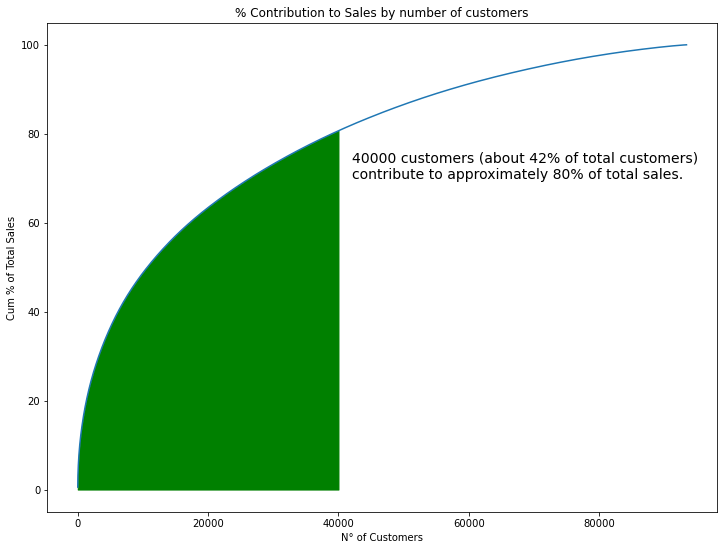

In [9]:
#Plotting
plt.figure(figsize=(12,9))
top_customers["% of Total Sales"] = (top_customers["payment_value"] / top_customers["payment_value"].sum()) * 100
top_customers["Cum % of Total Sales"] = top_customers["% of Total Sales"].cumsum()
ax = sns.lineplot(x=range(1,len(top_customers)+1), y="Cum % of Total Sales", data=top_customers)
ax.set_xlabel("N° of Customers")
ax.set_title("% Contribution to Sales by number of customers")

#filling with color the strongest cumulative part
a=np.arange(1,len(top_customers)+1)
b=top_customers["Cum % of Total Sales"]
plt.fill_between(a, b, 0,
                 where = (a >= 0) & (a <= 40000),
                 color = 'g')
ax.text(42000, 70, """40000 customers (about 42% of total customers) 
contribute to approximately 80% of total sales.""", fontsize=14)


#### 4.2 Who are the top customers?

Text(0.5, 1.0, 'Top 10 Customers by total paid')

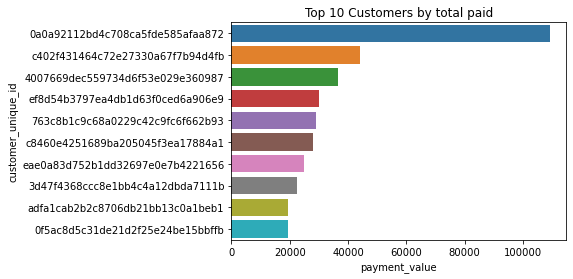

In [10]:
ax = sns.barplot(x="payment_value", y="customer_unique_id", data=top_customers[:10])
ax.set_title("Top 10 Customers by total paid")

#### 4.3 Where are the customers?


 we want to visualize the number of customers per state. To do this, we use the countplot() function from the Seaborn library and functions from the matplotlib library to add aesthetic value.

Text(0, 0.5, 'No. of Customers')

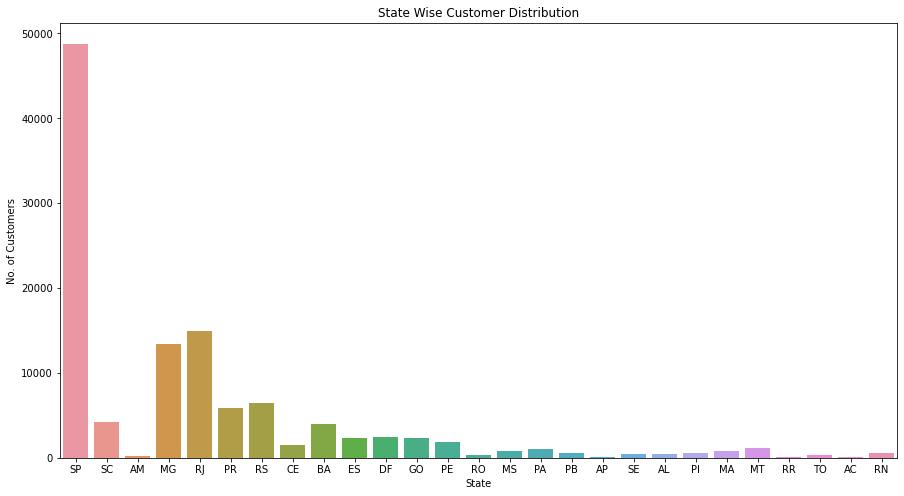

In [11]:
# plotting state wise customer distribution
plt.figure(figsize=(15,8))
sns.countplot(x='customer_state', data=join_data)
plt.title('State Wise Customer Distribution')
plt.xlabel('State')
plt.ylabel('No. of Customers')

The Geo Table comprises of the following table:

- geolocation_zip_code_prefix: first 5 digits of zip code.
- geolocation_lat: latitude
- geolocation_lng: longitude
- geolocation_city: city
- geolocation_state state

Let's now visualize the data points on a map. To do this, we use functions from the GeoPandas and Shapely libraries.

In [12]:
#geometry = [Point(xy) for xy in zip(geo['geolocation_lng'], geo['geolocation_lat'])]
#gdf = GeoDataFrame(geo, geometry=geometry)   

#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

As we can see, most of the orders come from Brazilian cities, however, there are a few orders which come from North America, Europe, and Asia.

#### 4.4 RFM Analysis


What is RFM analysis?

RFM stands for recency, frequency, monetary value. In business analytics, we often use this concept to divide customers into different segments, like high-value customers, medium value customers or low-value customers, and similarly many others.

Recency: How recently has the customer made a transaction with us

Frequency: How frequent is the customer in ordering/buying some product from us

Monetary: How much does the customer spend on purchasing products from us

let’s perform the RFM analysis on our customers

In [31]:
#Calculate recency
df_recency=join_data.groupby(by="customer_unique_id", as_index=False)["order_purchase_timestamp"].max()
df_recency.rename(columns={"order_purchase_timestamp":"Last_purchase_date"}, inplace=True)
df_recency["Last_purchase_date"]=pd.to_datetime(df_recency["Last_purchase_date"])
# Get recent invoice date and use it to calculate recency
recent_date=pd.to_datetime(join_data["order_purchase_timestamp"]).max()
df_recency["Recency"]=df_recency["Last_purchase_date"].apply(lambda x=None: (recent_date - x).days)
df_recency.head()

,customer_unique_id,Last_purchase_date,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,115
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,118
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,541
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,325
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,292


In [14]:
# Calculating frequency
frequency_df=join_data.groupby(["customer_unique_id"]).agg({"order_id":"nunique"}).reset_index() #nunique count times that a value appears
frequency_df.rename(columns={"order_id":"Frequency"}, inplace=True)
frequency_df.head()

,customer_unique_id,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [15]:
# Calculating monetary 
monetary_df=join_data.groupby("customer_unique_id", as_index=False)["payment_value"].sum()
monetary_df.columns=["customer_unique_id","Monetary"]
monetary_df.head()

,customer_unique_id,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89


In [16]:
# Merging dfs
rf_df=df_recency.merge(frequency_df, on="customer_unique_id")
rfm_df=rf_df.merge(monetary_df, on="customer_unique_id").drop(columns="Last_purchase_date")
rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19
2,0000f46a3911fa3c0805444483337064,541,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,292,1,196.89


In [17]:
# Remove zeros from data before log trans
rfm_df[rfm_df.columns[1:]]=rfm_df[rfm_df.columns[1:]].applymap(lambda x: 1 if x ==0 else x)


In [18]:
# Running K-Means algo to cluster our data
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    plt.show()
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

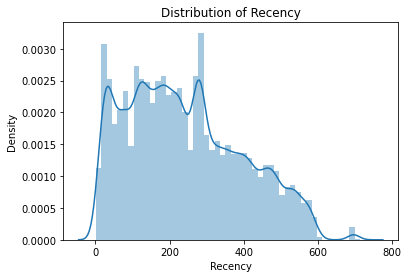

Recency's: Skew: 0.45255472888525733, : SkewtestResult(statistic=53.915411531040256, pvalue=0.0)


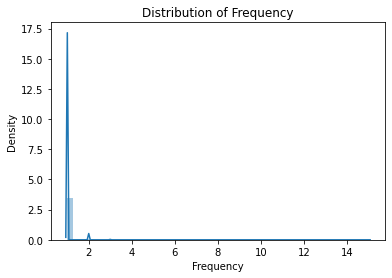

Frequency's: Skew: 10.990942154921314, : SkewtestResult(statistic=335.6456861541721, pvalue=0.0)


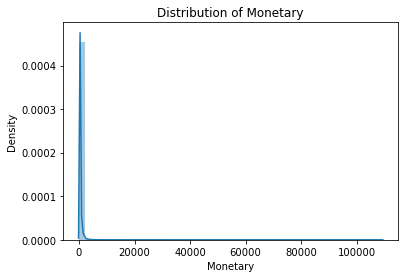

Monetary's: Skew: 70.33621193560055, : SkewtestResult(statistic=524.6379205104615, pvalue=0.0)


In [19]:
for col in rfm_df.columns[1:]:
    check_skew(rfm_df, col)

"A skewness value greater than 1 or less than -1 indicates a highly skewed distribution. A value between 0.5 and 1 or -0.5 and -1 is moderately skewed. A value between -0.5 and 0.5 indicates that the distribution is fairly symmetrical"

We'll log transform Frequency and Monetary as they are highly skwed.

In [20]:
# Perform log transformation 
rfm_df_log = rfm_df.copy()
for c in rfm_df.columns[2:]:
    rfm_df_log[c] = np.log10(rfm_df_log[c])

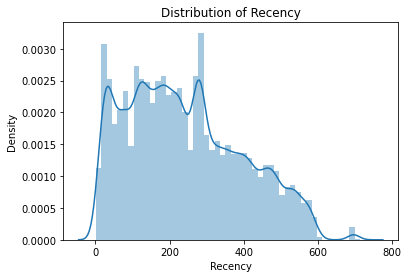

Recency's: Skew: 0.45255472888525733, : SkewtestResult(statistic=53.915411531040256, pvalue=0.0)


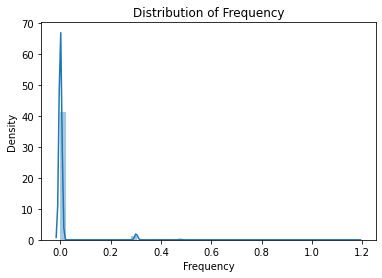

Frequency's: Skew: 6.068294981630156, : SkewtestResult(statistic=275.4417097222108, pvalue=0.0)


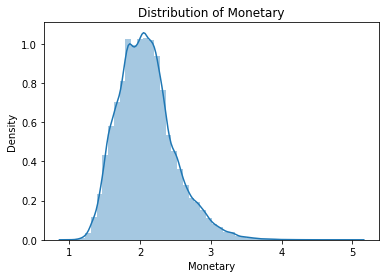

Monetary's: Skew: 0.729609897634013, : SkewtestResult(statistic=81.9204555191681, pvalue=0.0)


In [21]:
for col in rfm_df.columns[1:]:
    check_skew(rfm_df_log, col)

Now, I'll scale the data.

In [22]:
scaler = StandardScaler()
scaler.fit(rfm_df_log.drop("customer_unique_id", axis=1))
RFM_Table_scaled = scaler.transform(rfm_df_log.drop("customer_unique_id", axis=1))
# Put data into a df
RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns=rfm_df_log.columns[1:])

In [23]:
RFM_Table_scaled.head()

,Recency,Frequency,Monetary
0,-0.827507,-0.172439,0.164274
1,-0.807921,-0.172439,-1.635774
2,1.953827,-0.172439,-0.378506
3,0.543573,-0.172439,-1.120834
4,0.328117,-0.172439,0.521090


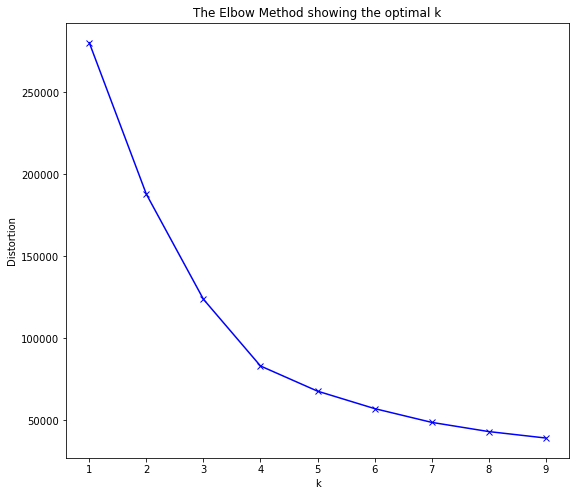

In [24]:
# Training k-means model

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(RFM_Table_scaled)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(9,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [25]:
# Train the model on 4 clusters
kmean_model = KMeans(n_clusters=4, random_state=5)
kmean_y = kmean_model.fit_predict(RFM_Table_scaled)
# Add labels to df
rfm_df['Cluster'] = kmean_model.labels_

In [26]:
# Function to visualize clusters
def rfm_values(df):
    df_new = df.groupby(['Cluster']).agg({
            'Recency': 'mean',
            'Frequency': 'mean',
            'Monetary': ['mean', 'count']
        }).round(0)

    return df_new

In [27]:
rfm_values(rfm_df)

Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0         145.0       1.0     82.0  40308
1         225.0       2.0    488.0   2807
2         425.0       1.0    124.0  27541
3         193.0       1.0    521.0  22740

The Frequency feature doesn't add that much value to the model since in our data most customers have made on average only one order (mean order per customer is 1.03). Moreover, most customers haven't ordered in a while.

What does each cluster represent?

Cluster 0 : This cluster can be interpreted as (Relatively New Comers/Low spenders) as their spending is the smallest among all clusters but have the lowest recency. This cluster is quite huge. So, some marketing effort could be advisable towards it in order to increase its monetary value.

Cluster 1 : can be considered as our best one (Loyal customers) since although customers in this cluster haven't on avergae ordered in a while, their frequency of orders is greater than all other clusters and the value of their orders is quite high.

Cluster 3 : (Lost/Low spenders) is the name we can give to this cluster. Customers in this cluster seem have one of the highest recency and their monetary value is low. This cluster shouldn't be the focus of marketing effort.

Cluster 4 : This is our second best (Big spenders) cluster as it's recency comes second and the average amount spent is largest. This cluster is also second in terms of number of customers.

### 5.- Sellers Analysis

#### 5.1 ¿Where are more sellers?

In [88]:
total_sellers=olist_sellers["seller_id"].count()
sellers_state=olist_sellers.groupby("seller_state", as_index=False)["seller_id"].count()
sellers_state["state_proportion"]=sellers_state["seller_id"]*100/total_sellers
sellers_state.sort_values(by=['state_proportion'], inplace=True, ascending= False)
print(sellers_state)

   seller_state  seller_id  state_proportion
22           SP       1849         59.741519
15           PR        349         11.276252
8            MG        244          7.883683
20           SC        190          6.138934
16           RJ        171          5.525040
19           RS        129          4.168013
6            GO         40          1.292407
4            DF         30          0.969305
5            ES         23          0.743134
2            BA         19          0.613893
3            CE         13          0.420032
13           PE          9          0.290792
12           PB          6          0.193861
9            MS          5          0.161551
17           RN          5          0.161551
10           MT          4          0.129241
18           RO          2          0.064620
21           SE          2          0.064620
0            AC          1          0.032310
14           PI          1          0.032310
1            AM          1          0.032310
7         

It seems SP y PR are the 2 most states with sellers, the first one has more than 59% percent of them

#### 5.2 ¿Who are the top 10 sellers with most orders?

In [84]:
seller_q=olist_order_items.groupby("seller_id", as_index=False)["order_id"].count()
seller_q.sort_values(by=['order_id'], inplace=True, ascending= False)
print(seller_q.head(10))

                             seller_id  order_id
1235  6560211a19b47992c3666cc44a7e94c0      2033
881   4a3ca9315b744ce9f8e9374361493884      1987
368   1f50f920176fa81dab994f9023523100      1931
2481  cc419e0650a3c5ba77189a1882b7556a      1775
2643  da8622b14eb17ae2831f4ac5b9dab84a      1551
1824  955fee9216a65b617aa5c0531780ce60      1499
192   1025f0e2d44d7041d6cf58b6550e0bfa      1428
1535  7c67e1448b00f6e969d365cea6b010ab      1364
2836  ea8482cd71df3c1969d7b9473ff13abc      1203
1505  7a67c85e85bb2ce8582c35f2203ad736      1171


#### ¿Who are the top 10 sellers with the most revenue? ¿Are the same top 10 above?

In [87]:
seller_r=olist_order_items.groupby("seller_id", as_index=False)["price"].sum()
seller_r.sort_values(by=['price'], inplace=True, ascending= False)
print(seller_r.head(10))

                             seller_id      price
857   4869f7a5dfa277a7dca6462dcf3b52b2  229472.63
1013  53243585a1d6dc2643021fd1853d8905  222776.05
881   4a3ca9315b744ce9f8e9374361493884  200472.92
3024  fa1c13f2614d7b5c4749cbc52fecda94  194042.03
1535  7c67e1448b00f6e969d365cea6b010ab  187923.89
1560  7e93a43ef30c4f03f38b393420bc753a  176431.87
2643  da8622b14eb17ae2831f4ac5b9dab84a  160236.57
1505  7a67c85e85bb2ce8582c35f2203ad736  141745.53
192   1025f0e2d44d7041d6cf58b6550e0bfa  138968.55
1824  955fee9216a65b617aa5c0531780ce60  135171.70


That's interesting, they're not the same. But that might be obvious because maybe some sellers sold lees but their items are expensive